Loading data from datasets

In [10]:
import pandas as pd

data_train = pd.read_csv("sample_data/train.tsv", sep="\t", header=None)
data_valid = pd.read_csv("sample_data/valid.tsv", sep="\t", header=None)
data_test = pd.read_csv("sample_data/test.tsv", sep="\t", header=None)

In [11]:
#Viewing sample train data before preprocessing
data_train.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver


In [12]:
#Viewing sample train data counts
data_train.shape

(10240, 14)

In [13]:
#Viewing count of data in seprate of labels
# Filter the DataFrame based on the label
filtered_data1 = data_train[data_train.iloc[:, 1] ==  'false']
filtered_data2 = data_train[data_train.iloc[:, 1]  == "pants-fire"]
filtered_data3 = data_train[data_train.iloc[:, 1]  == "true"]
filtered_data4 = data_train[data_train.iloc[:, 1]  == "mostly-true"]
filtered_data5 = data_train[data_train.iloc[:, 1]  == "half-true"]
filtered_data6 = data_train[data_train.iloc[:, 1]  == "barely-true"]
# Display the result
print(f"The number of rows with label false is: {filtered_data1.shape[0]}")
print(f"The number of rows with label pants-fire is: {filtered_data2.shape[0]}")
print(f"The number of rows with label true is: {filtered_data3.shape[0]}")
print(f"The number of rows with label mostly-true is: {filtered_data4.shape[0]}")
print(f"The number of rows with label half-true is: {filtered_data5.shape[0]}")
print(f"The number of rows with label barely-true is: {filtered_data6.shape[0]}")

The number of rows with label false is: 1995
The number of rows with label pants-fire is: 839
The number of rows with label true is: 1676
The number of rows with label mostly-true is: 1962
The number of rows with label half-true is: 2114
The number of rows with label barely-true is: 1654


convert 6 classes to 2 classes

In [14]:
def combine_classes(dataset):
    #Creating new column called 'label' with 1 for true and mostly-true values, else 0 i.e. 1=real, 0=fake
    dataset['label']=[1 if x=="true"or x=="mostly-true" else 0 for x in dataset[1]]
    
    #Dealing with empty datapoints for metadata columns - subject, speaker, job, state,affiliation, context
    meta = []
    for i in range(len(dataset)):
      subject = dataset[3][i]
      if subject == 0:
          subject = 'None'

      speaker =  dataset[4][i]
      if speaker == 0:
          speaker = 'None'

      job =  dataset[5][i]
      if job == 0:
          job = 'None'

      state =  dataset[6][i]
      if state == 0:
          state = 'None'

      affiliation =  dataset[7][i]
      if affiliation == 0:
          affiliation = 'None'

      context =  dataset[13][i]
      if context == 0 :
          context = 'None'

      meta.append(str(subject) + ' ' + str(speaker) + ' ' + str(job) + ' ' + str(state) + ' ' + str(affiliation) + ' ' + str(context)) #combining all the meta data columns into a single column
  
    #Adding cleaned and combined metadata column to the dataset
    dataset[14] = meta
    dataset["sentence"] = dataset[2]
    
    #Dropping unwanted columns
    dataset = dataset.drop(labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13] ,axis=1)
    dataset.dropna() #Dropping if there are still any null values
    return dataset

In [15]:
#Applying reduce_classes to the raw data - train, valid and test sets
data_train = combine_classes(data_train)
data_valid = combine_classes(data_valid)
data_test = combine_classes(data_test)
data_train.head(3)


,label,14,sentence
0,0,abortion dwayne-bohac State representative Tex...,Says the Annies List political group supports ...
1,0,"energy,history,job-accomplishments scott-surov...",When did the decline of coal start? It started...
2,1,foreign-policy barack-obama President Illinois...,"Hillary Clinton agrees with John McCain ""by vo..."


In [16]:
#Viewing count of data in seprate of labels
data_train['label'].value_counts(normalize='true')

0    0.644727
1    0.355273
Name: label, dtype: float64

Preproccesing

In [17]:
#importing required packages  
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

def data_preprocessing(dataset):
    preprocessed_texts = []
    for text in dataset:
        # convert to lowercase
        text = text.lower()    
        # tokenize text
        tokens = word_tokenize(text)
        # remove punctuation and irrelevant characters
        filtered_tokens = [token for token in tokens if token.isalnum()]
        # remove stop words
        stop_words = set(stopwords.words('english'))
        filtered_tokens = [token for token in filtered_tokens if not token in stop_words]
        # lemmatize tokens
        lemmatizer = WordNetLemmatizer()
        filtered_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
        # stem tokens
        stemmer = PorterStemmer()
        filtered_tokens = [stemmer.stem(token) for token in filtered_tokens]
        # join tokens back into string
        preprocessed_text = ' '.join(filtered_tokens)
        preprocessed_texts.append(preprocessed_text)
    return preprocessed_texts

In [18]:
#Applying pre-processing to the raw data - train, valid and test sets
data_train['sentence'] = data_preprocessing(data_train['sentence'])
data_valid['sentence'] = data_preprocessing(data_valid['sentence'])
data_test['sentence'] = data_preprocessing(data_test['sentence'])

data_train["sentence"] = data_train["sentence"] + " " + data_train[14].astype('str') #Combining metadata and the text columns into single columns
data_valid["sentence"] = data_valid["sentence"] + " " + data_valid[14].astype('str') #Combining metadata and the text columns into single columns
data_test["sentence"] = data_test["sentence"] + " " + data_test[14].astype('str') #Combining metadata and the text columns into single columns

data_train = data_train.drop(labels=[14] ,axis=1)
data_valid = data_valid.drop(labels=[14] ,axis=1)
data_test = data_test.drop(labels=[14] ,axis=1)

#Sample data after preprocessing
data_train.head(5)

,label,sentence
0,0,say anni list polit group support abort demand...
1,0,declin coal start start natur ga took start be...
2,1,hillari clinton agre john mccain vote give geo...
3,0,health care reform legisl like mandat free sex...
4,0,"econom turnaround start end term economy,jobs ..."


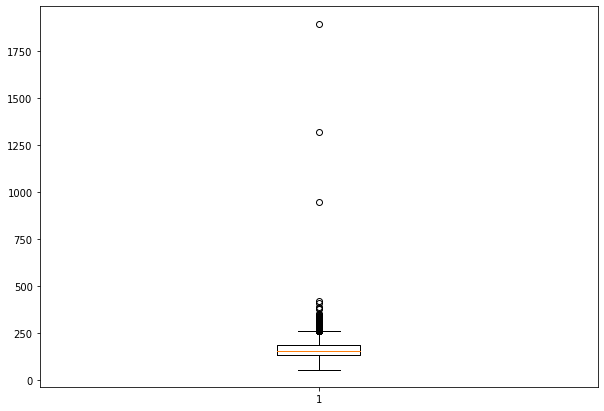

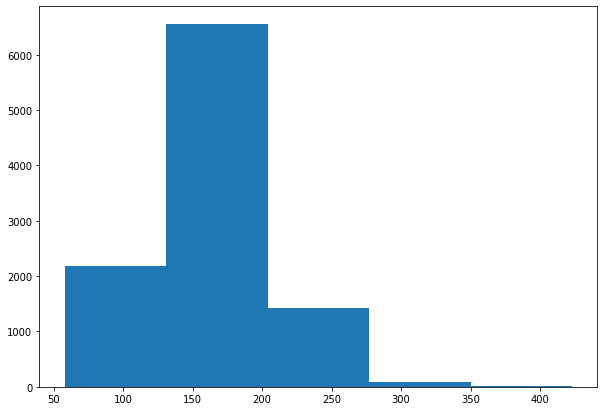

In [19]:
#Analyzing length of sentences in training data to decide on MAX_LENGTH variable, which is required for mlp and deep_leaner

sent_len = []
for sent in data_train['sentence']:
  sent_len.append(len(sent))

import matplotlib.pyplot as plt

fig = plt.figure(figsize =(10, 7))
plt.boxplot(sent_len)
plt.show()

sent_len = [i for i in sent_len if i<=500] #Excluding the outliers
fig2 = plt.figure(figsize =(10, 7))
plt.hist(sent_len, 5)
plt.show()

First plot:The x-axis represents the sentence length, while the y-axis represents the distribution of lengths.

Second Histogram: It shows a histogram of the sentence lengths after excluding any outliers greater than 500 characters From the above histogram. The x-axis represents the range of sentence lengths, divided into bins (in this case, 5 bins), and the y-axis represents the frequency or count of sentences falling within each bin.The histogram provides insight into the distribution of sentence lengths and highlights any patterns or concentration of lengths within the dataset.

we can see that, majority of the sentences are in the range of 100-150 and the maximum is near 300.

Ensemble Model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from keras.utils.vis_utils import plot_model

def create_ensemble_models(X_train, y_train, X_val, y_val):
    num_models = 3
    models = []
    
    for i in range(num_models):
        model = Sequential()
        
        model.add(Embedding(vocab_size, 50, input_length=max_len))
        model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, name=f'lstm_layer_{i}'))
        #model.add(Dense(64, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=64)
        
        models.append(model)

    return models

In [31]:
import numpy as np

def predict_ensemble_models(X_valid, X_test, y_valid, y_test, models):
    # Make predictions on the validation set
    y_pred_ensemble_valid = np.zeros_like(y_valid, dtype=np.float64)
    for i in range(len(models)):
        y_pred_valid = models[i].predict(X_valid)
        y_pred_ensemble_valid += np.squeeze((y_pred_valid > 0.5).astype(int))

    y_pred_ensemble_valid /= 3
    y_pred_ensemble_valid = np.round(y_pred_ensemble_valid).astype(int)

    # Make predictions on the test set
    y_pred_ensemble = np.zeros_like(y_test, dtype=np.float64)
    for i in range(len(models)):
        y_pred = models[i].predict(X_test)
        y_pred_ensemble += np.squeeze((y_pred > 0.5).astype(int))
    y_pred_ensemble /= 3
    y_pred_ensemble = np.round(y_pred_ensemble).astype(int)

    return y_pred_ensemble_valid, y_pred_ensemble

In [24]:
#part 1
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_train['sentence'])
vocab_size = len(tokenizer.word_index) + 1

X_train = tokenizer.texts_to_sequences(data_train['sentence'])
X_valid = tokenizer.texts_to_sequences(data_valid['sentence'])
X_test = tokenizer.texts_to_sequences(data_test['sentence'])

max_len = 200  # Define the maximum sequence length
X_train = pad_sequences(X_train, maxlen=max_len)
X_valid = pad_sequences(X_valid, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

y_train = np.array(data_train['label'])  # Convert to numpy array
y_valid = np.array(data_valid['label'])  # Convert to numpy array
y_test = np.array(data_test['label'])  # Convert to numpy array

In [25]:
#Part2 : Create ensemble model
models = create_ensemble_models(X_train, y_train,X_valid, y_valid)

Epoch 1/5
160/160 [==============================] - 89s 519ms/step - loss: 0.6387 - accuracy: 0.6441 - val_loss: 0.6029 - val_accuracy: 0.6768
Epoch 2/5
160/160 [==============================] - 81s 507ms/step - loss: 0.5715 - accuracy: 0.6982 - val_loss: 0.5921 - val_accuracy: 0.6854
Epoch 3/5
160/160 [==============================] - 77s 484ms/step - loss: 0.4838 - accuracy: 0.7665 - val_loss: 0.6146 - val_accuracy: 0.6885
Epoch 4/5
160/160 [==============================] - 83s 520ms/step - loss: 0.4052 - accuracy: 0.8142 - val_loss: 0.6608 - val_accuracy: 0.6604
Epoch 5/5
160/160 [==============================] - 85s 531ms/step - loss: 0.3296 - accuracy: 0.8565 - val_loss: 0.7921 - val_accuracy: 0.6519
Epoch 1/5
160/160 [==============================] - 84s 495ms/step - loss: 0.6383 - accuracy: 0.6471 - val_loss: 0.6021 - val_accuracy: 0.6854
Epoch 2/5
160/160 [==============================] - 81s 506ms/step - loss: 0.5619 - accuracy: 0.7090 - val_loss: 0.5928 - val_accuracy:

In [32]:
y_pred_ensemble_valid, y_pred_ensemble = predict_ensemble_models(X_valid, X_test, y_valid, y_test, models)

40/40 [==============================] - 1s 32ms/step


In [33]:
from sklearn.metrics import f1_score, classification_report

# Print classification report
f_score = f1_score(data_test['label'], y_pred_ensemble, average='micro')
print("Model3 - Ensemble F1-score:", f_score)
print("Model3 - Classification Report:")
print(classification_report(data_test['label'], y_pred_ensemble))

Model3 - Ensemble F1-score: 0.611681136543015
Model3 - Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.71      0.70       818
           1       0.45      0.44      0.45       449

    accuracy                           0.61      1267
   macro avg       0.57      0.57      0.57      1267
weighted avg       0.61      0.61      0.61      1267



MLP Classifier

In [34]:
from sklearn.neural_network import MLPClassifier

def build_mlp():
    # Step 1: increase the training data with ensemble predictions
    X_train_increased = np.concatenate((X_valid, y_pred_ensemble_valid[:len(X_valid)].reshape(-1, 1)), axis=1)

    mlp_classifier = MLPClassifier()
    mlp_classifier.fit(X_train_increased, y_valid)

    X_test_increased = np.concatenate((X_test, y_pred_ensemble.reshape(-1, 1)), axis=1)

    mlp_predictions = mlp_classifier.predict(X_test_increased)
    return mlp_predictions

In [35]:
mlp_predictions = build_mlp()

In [36]:
from sklearn.metrics import accuracy_score

# Calculate F-score and accuracy
f_score = f1_score(y_test, mlp_predictions, average='micro')
accuracy = accuracy_score(y_test, mlp_predictions)
print(classification_report(y_test, mlp_predictions))

print("Model3 - MLP F-score:", f_score)
print("Model3 - MLP Accuracy:", accuracy)

              precision    recall  f1-score   support

           0       0.64      0.63      0.64       818
           1       0.35      0.36      0.35       449

    accuracy                           0.53      1267
   macro avg       0.49      0.49      0.49      1267
weighted avg       0.54      0.53      0.54      1267

Model3 - MLP F-score: 0.5335438042620363
Model3 - MLP Accuracy: 0.5335438042620363
